In [288]:
import xray
%matplotlib inline
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

In [318]:
keep_vars = ['iDEPTH', 'iPROF', 'depth', 'prof_YYYYMMDD',
             'prof_HHMMSS', 'prof_lon', 'prof_lat']

mydepth = 300

def extract_ds(ds, depth, data_var, all_vars):
    all_vars = keep_vars + [data_var,]
    for v in ds.variables:
        if v not in all_vars:
            ds = ds.drop(v)
    didx = ds['depth'].to_index()
    idepth = didx.get_loc(depth, method='nearest')
    # time
    if data_var in ds.variables:
        ds = ds.isel(iDEPTH=idepth)#.drop('iDEPTH')
        date = pd.to_datetime(ds.prof_YYYYMMDD, format='%Y%m%d')
        ds['date'] = xray.DataArray(date, coords={'iPROF': ds.iPROF.values})
        ds = ds.assign_coords(date=ds.date, prof_lon=ds.prof_lon,
                          prof_lat=ds.prof_lat, depth=ds.depth)
        ds = ds.drop(['prof_YYYYMMDD', 'prof_HHMMSS'])
        return ds
    else:
        return None

dsets = {}
for data_var in ['prof_T', 'prof_S']:
    dslist = []
    
    for n, f in enumerate(glob('/data/scratch/rpa/SOSE/data/*.nc')):
        # check for model file
        l = os.path.basename(f).split('.')
        l.insert(-1, 'equi.all')
        mfname = os.path.join(os.path.dirname(f),'model_equiv',str.join('.',l))
        if os.path.exists(mfname):
            ds1 = xray.open_dataset(f)
            ds2 = xray.open_dataset(mfname)
            obs, sose = [extract_ds(ds, mydepth, data_var, keep_vars)
                         for ds in [ds1,ds2]]
            if obs:
                obs.rename({data_var: data_var + '_obs'}, inplace=True)
            if sose:
                sose.rename({data_var: data_var + '_sose'}, inplace=True)
            if obs and sose:
                ds = obs.merge(sose)
                dslist.append(ds)
                
            #dslist.append(newds)
    dsets[data_var] = xray.concat(dslist, dim='iPROF',
                                  data_vars=[data_var+'_obs', data_var+'_sose'])

In [298]:
from mpl_toolkits.basemap import Basemap
def southern_ocean_basemap(boundinglat=-60., ax=None,
                              labels=[1,0,0,1], 
                              land=True, grid=True, **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat, lon_0=180., ax=ax)
    if land:
        m.drawcoastlines()
        m.fillcontinents(color='0.7',lake_color='0.5')
    # draw parallels and meridians.
    if grid:
        m.drawparallels(np.arange(-80.,81.,10.))
        m.drawmeridians(np.arange(-180.,181.,30.), labels=labels)
    m.drawmapboundary(fill_color='0.2')

    return m

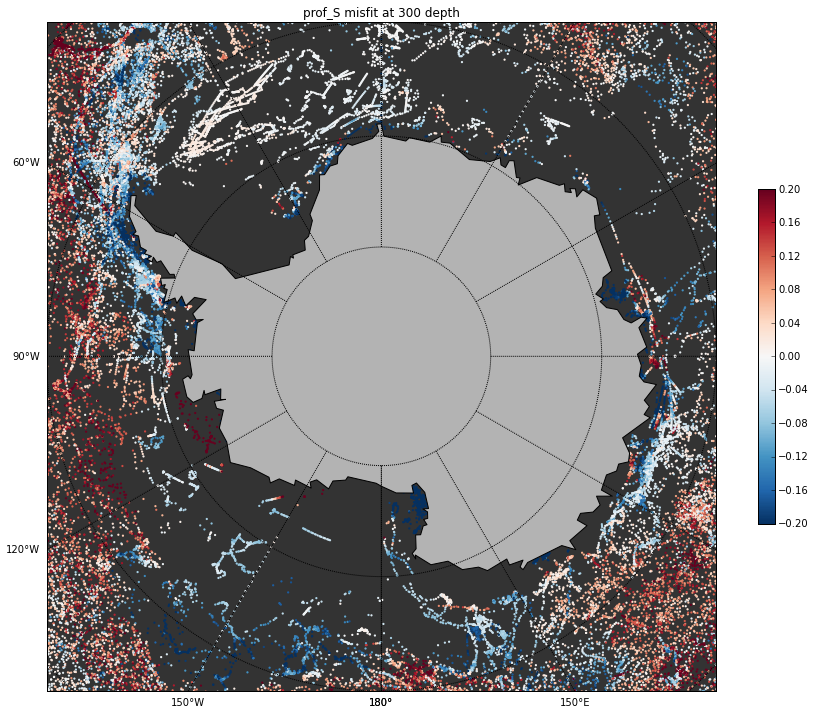

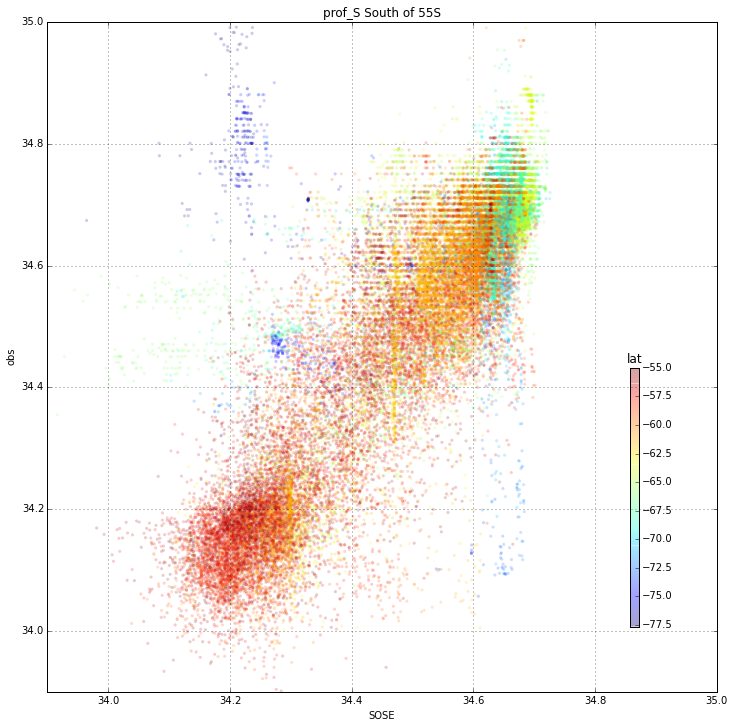

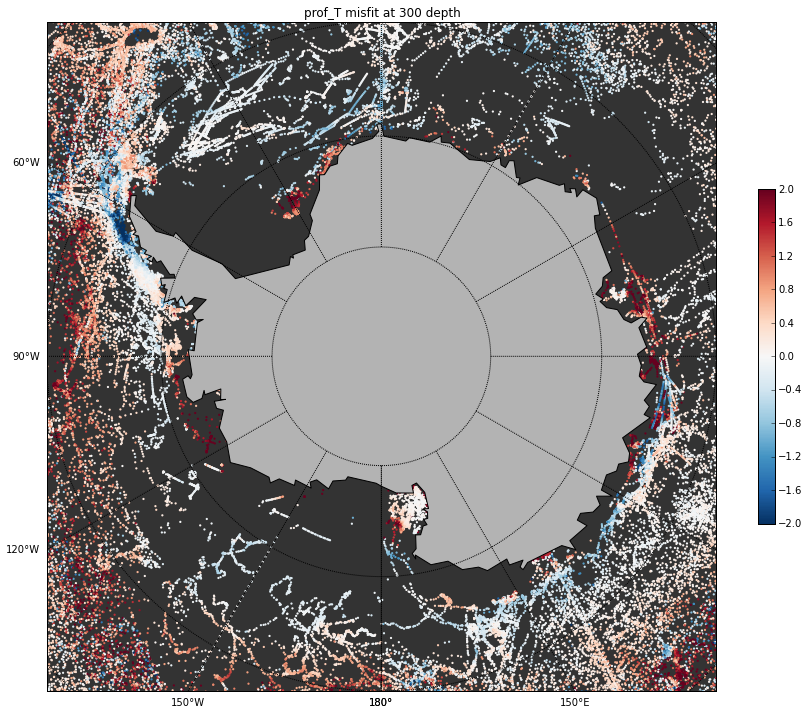

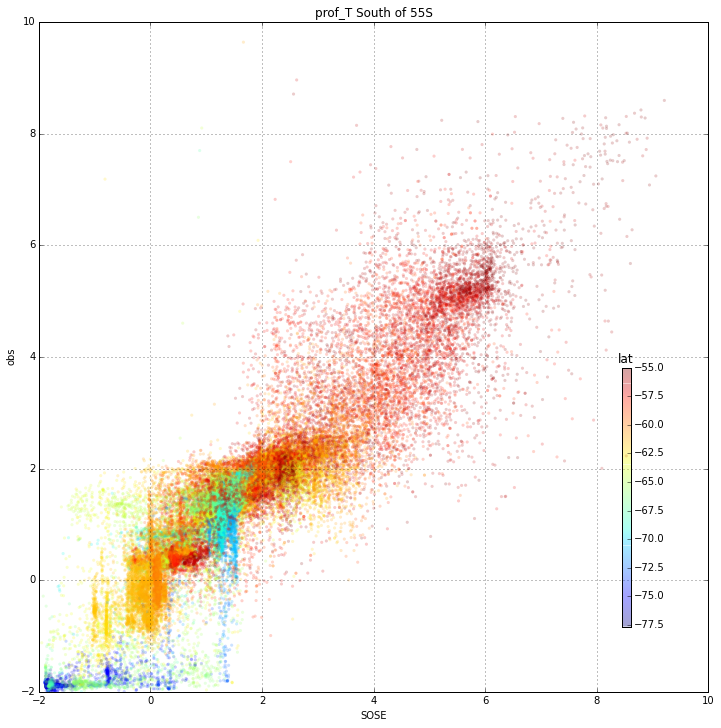

In [345]:
for vname, lev, vrange in [('prof_S', 0.2, (33.9,35.)),
                           ('prof_T', 2.0, (-2,10))]:

    ds = dsets[vname]
    N = len(ds.iPROF) #100000
    lon = ds.prof_lon.values[:N]
    lat = ds.prof_lat.values[:N]

    sose = ds[vname + '_sose'].values
    obs = ds[vname + '_obs'].values
    T = sose - obs

    # I thought there were some weird 0 values
    idx = (lat<-55) & (obs!=0.0000) & (sose!=0.0000)
    plt.figure(figsize=(15,15))
    ax = plt.subplot(111, axisbg='0.3')
    m = southern_ocean_basemap(ax=ax)
    x, y = m(lon,lat)
    scat = m.scatter(x, y, c=T, edgecolor='none', cmap='RdBu_r', s=5, alpha=1.0)
    scat.set_clim([-lev,lev])
    plt.colorbar(scat, shrink=0.4)
    plt.title(vname + ' misfit at %g depth' % mydepth)
    plt.figure(figsize=(12,12))

    s2=plt.scatter( sose[idx], obs[idx],  edgecolor='none',
                 c=lat[idx], cmap='jet', s=10, alpha=0.2)
    plt.xlim(vrange)
    plt.ylim(vrange)
    plt.grid()
    plt.xlabel('SOSE')
    plt.ylabel('obs')
    plt.title(vname + ' South of 55S')

    plt.colorbar(s2,  cax=plt.axes((0.8,0.2,0.01,0.3)))
    plt.title('lat')          